# Optimal Feature Selection with Qiskit (Finance Data)

In [2]:
from sklearn.datasets import load_boston
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model

from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.aqua.algorithms import QAOA
from qiskit import Aer

%matplotlib inline
from qiskit.finance import QiskitFinanceError
from qiskit.finance.data_providers import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from qiskit import IBMQ, execute

In [3]:
########################
from qiskit.aqua.operators import PauliExpectation, CVaRExpectation
from qiskit import IBMQ
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q-internal', 'deployed', 'default')
hw_backend = provider.get_backend('ibmq_paris')
########################

/Users/ouf/Documents/GitHub/qiskit-ibmq-provider/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
data = YahooDataProvider(
                tickers = ["GOOG", "AMZN", "AAPL", "MSFT", "DHR", "DOCU", 
                           "TSLA", "ZM", "TCEHY", "NFLX", "AMD", "AMZN",
                          "IBM", "BABA"],
             start=datetime.datetime(2020, 7, 1),
             end=datetime.datetime(2020, 9, 1))
data.run()


Y_data = np.transpose(np.array(data._data[0]))

X_data = np.array([])
X_data = [np.append(X_data, np.array(data._data[1]))]
for i in range(2,len(data._tickers)):
    X_data = np.append(X_data, [np.array(data._data[i])], axis=0)
X_data = np.transpose(X_data)

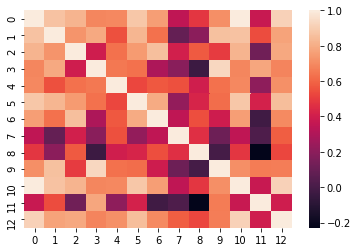

In [4]:
corr = np.corrcoef(X_data, rowvar=False)
sns.heatmap(corr);

In [5]:
n = X_data.shape[1]  # number of available features
k = 6           # number of features to be selected

print('Goal: select %s out of %s features' % (k, n))

Goal: select 6 out of 13 features


$$
\max_{x \in \{0, 1\}^n} \sum_{i, j=0}^{n-1} |\rho_{ij}|x_i (1 - x_j) \\
\text{subject to:} \sum_{i=0}^{n-1} x_i = k
$$

In [6]:
# initialize optimization problem
mdl = Model('feature_selection')

# create list of binary variabels
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

# define objective function
objective = mdl.sum(abs(corr[i][j])*x[i]*(1 - x[j]) for i in range(n) for j in range(n))
mdl.maximize(objective)
# mdl.minimize(objective)

# add constraint to fix number of features to be selected
mdl.add_constraint(mdl.sum(x) == k);

# print resulting model
# mdl.pprint()

solution = mdl.solve()
print(solution)
selection = np.where(solution.get_all_values())[0]
print('Selection:', selection)

# load into Qiskit QuadraticProgram
qp = QuadraticProgram()
qp.from_docplex(mdl)

solution for: feature_selection
objective: 25.1018
x2=1
x4=1
x5=1
x10=1
x11=1
x12=1

Selection: [ 2  4  5 10 11 12]


# Evaluate Feature Selection

RFE selection: [ 1  2  4  5 11 12]


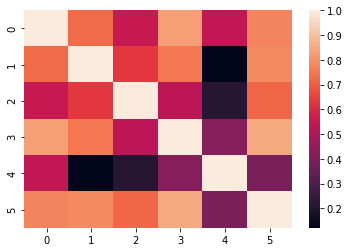

In [7]:
# initialize the regression algorithm to be used
estimator = LinearRegression()

# Recursive Feature Elimination
selector = RFE(estimator, n_features_to_select=k, step=1)
selector = selector.fit(X_data, Y_data)
selection_rfe = np.where(selector.get_support())[0]
print('RFE selection:', selection_rfe)
sns.heatmap(np.corrcoef(X_data[:, selection_rfe], rowvar=False));

In [8]:
# split into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state=42)

def evaluate(estimator, x_train_, y_train, x_test_, y_test):
            
    # fit esitmator
    estimator.fit(x_train_, y_train)

    # apply linear regression
    y_pred = estimator.predict(x_test_)
    
    # evaluate performance metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    return r2, mse

In [9]:
# apply RFE feature selection
x_train_rfe = x_train[:, selection_rfe]
x_test_rfe = x_test[:, selection_rfe]

In [10]:
rfe_eval = evaluate(estimator, x_train_rfe, y_train, x_test_rfe, y_test)

print('Approach\tR2\tMSE')
print('------------------------------')
print('RFE     \t%.3f\t%.2f' % (rfe_eval[0], rfe_eval[1]))

Approach	R2	MSE
------------------------------
RFE     	0.841	540.75


# VQE Ansaetze

In [16]:
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQE
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Collect2qBlocks

from qiskit.opflow import StateFn, MatrixOp

theta = Parameter('theta')

qc_ent = QuantumCircuit(2)
qc_ent.rxx(theta, 0, 1)
qc_ent.ryy(theta, 0, 1)
qc_ent.draw()

┌─────────────┐┌─────────────┐
q_0: ┤0            ├┤0            ├
     │  RXX(theta) ││  RYY(theta) │
q_1: ┤1            ├┤1            ├
     └─────────────┘└─────────────┘

In [24]:
param_swap = lambda t: [[1, 0,0 ,0], [0, 0, np.exp(1j * t), 0],[0, np.exp(1j * t), 0, 0], [0, 0, 0, 1]]
qc_ent = QuantumCircuit(2)
qc_ent.x(0)
# qc_ent.x(1)
op = MatrixOp(param_swap(-np.pi/8))
state =  op @ StateFn(qc_ent)

In [25]:
state.eval()

VectorStateFn(Statevector([0.        +0.j         0.        +0.j
             0.92387953-0.38268343j 0.        +0.j        ]), coeff=1.0, is_measurement=False)

In [12]:
qc_ent_ = qc_ent.bind_parameters({theta: 1.23})
qc_ent_.decompose().draw()

┌───┐                                  ┌───┐┌──────────┐     »
q_0: ┤ H ├──■────────────────────────────■──┤ H ├┤ RX(pi/2) ├──■──»
     ├───┤┌─┴─┐┌──────────────────────┐┌─┴─┐├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├┤ X ├┤ RZ(1.23000000000000) ├┤ X ├┤ H ├┤ RX(pi/2) ├┤ X ├»
     └───┘└───┘└──────────────────────┘└───┘└───┘└──────────┘└───┘»
«                                  ┌───────────┐
«q_0: ──────────────────────────■──┤ RX(-pi/2) ├
«     ┌──────────────────────┐┌─┴─┐├───────────┤
«q_1: ┤ RZ(1.23000000000000) ├┤ X ├┤ RX(-pi/2) ├
«     └──────────────────────┘└───┘└───────────┘

In [21]:
n = 13
k = 6

qc = QuantumCircuit(n)

for i in range(0, 11, 2):
    theta_i = Parameter('theta%s' % (i//2))
    qc.ry(theta_i, i)
    
    # 1. entangled option
    qc.x(i+1)
    qc.cx(i, i+1)
    
#     # 2. non-entangled option
#     qc.ry(theta_i + np.pi/2, i+1)
# for i in range(13):
#     theta_i = Parameter('theta%s' % i)
#     qc.ry(theta_i,i)
    
entanglement = [(i, (i+1) % n) for i in range(1, n, 2)] # + [(i, i+1) for i in range(0, n-1, 2)]
    
qc += TwoLocal(n, rotation_blocks=None, reps=1, entanglement_blocks=qc_ent, entanglement=entanglement)
qc.draw(fold=120)

┌────────────┐                                 
 q_0: ┤ RY(theta0) ├──■──────────────────────────────
      └───┬───┬────┘┌─┴─┐┌────────────┐┌────────────┐
 q_1: ────┤ X ├─────┤ X ├┤0           ├┤0           ├
      ┌───┴───┴────┐└───┘│  RXX(θ[0]) ││  RYY(θ[0]) │
 q_2: ┤ RY(theta1) ├──■──┤1           ├┤1           ├
      └───┬───┬────┘┌─┴─┐├────────────┤├────────────┤
 q_3: ────┤ X ├─────┤ X ├┤0           ├┤0           ├
      ┌───┴───┴────┐└───┘│  RXX(θ[1]) ││  RYY(θ[1]) │
 q_4: ┤ RY(theta2) ├──■──┤1           ├┤1           ├
      └───┬───┬────┘┌─┴─┐├────────────┤├────────────┤
 q_5: ────┤ X ├─────┤ X ├┤0           ├┤0           ├
      ┌───┴───┴────┐└───┘│  RXX(θ[2]) ││  RYY(θ[2]) │
 q_6: ┤ RY(theta3) ├──■──┤1           ├┤1           ├
      └───┬───┬────┘┌─┴─┐├────────────┤├────────────┤
 q_7: ────┤ X ├─────┤ X ├┤0           ├┤0           ├
      ┌───┴───┴────┐└───┘│  RXX(θ[3]) ││  RYY(θ[3]) │
 q_8: ┤ RY(theta4) ├──■──┤1           ├┤1           ├
      └───┬───┬────┘┌─┴─┐├────────────┤├────────────┤
 q_9: ────┤ X ├─────┤ X ├┤0           ├┤0           ├
      ┌───┴───┴────┐└───┘│  RXX(θ[4]) ││  RYY(θ[4]) │
q_10: ┤ RY(theta5) ├──■──┤1           ├┤1           ├
      └───┬───┬────┘┌─┴─┐├────────────┤├────────────┤
q_11: ────┤ X ├─────┤ X ├┤0           ├┤0           ├
          └───┘     └───┘│  RXX(θ[5]) ││  RYY(θ[5]) │
q_12: ───────────────────┤1           ├┤1           ├
                         └────────────┘└────────────┘

In [14]:
pm = PassManager(Collect2qBlocks())
qc_t = pm.run(qc)
# print(qc_t.depth())
qc_t = qc.decompose().decompose().decompose()
qc_t.draw()
params = {p: np.random.randn(qc.num_parameters)[i] for i, p in enumerate(qc.parameters)}
qc_t = qc_t.bind_parameters(params)
qc_t = pm.run(qc_t)
qc_t.draw()

global phase: 1.44349329296476
      ┌───────────────────────────┐                            »
 q_0: ┤ U3(-2.68765712219565,0,0) ├───■────────────────────────»
      └──────┬─────────────┬──────┘ ┌─┴─┐┌───────────────┐     »
 q_1: ───────┤ U3(pi,0,pi) ├────────┤ X ├┤ U3(pi/2,0,pi) ├──■──»
      ┌──────┴─────────────┴───────┐└───┘├───────────────┤┌─┴─┐»
 q_2: ┤ U3(-0.957825216565686,0,0) ├──■──┤ U3(pi/2,0,pi) ├┤ X ├»
      └──────┬─────────────┬───────┘┌─┴─┐├───────────────┤└───┘»
 q_3: ───────┤ U3(pi,0,pi) ├────────┤ X ├┤ U3(pi/2,0,pi) ├──■──»
      ┌──────┴─────────────┴───────┐└───┘├───────────────┤┌─┴─┐»
 q_4: ┤ U3(-0.268200900123696,0,0) ├──■──┤ U3(pi/2,0,pi) ├┤ X ├»
      └──────┬─────────────┬───────┘┌─┴─┐├───────────────┤└───┘»
 q_5: ───────┤ U3(pi,0,pi) ├────────┤ X ├┤ U3(pi/2,0,pi) ├──■──»
      ┌──────┴─────────────┴──────┐ └───┘├───────────────┤┌─┴─┐»
 q_6: ┤ U3(0.895033734147229,0,0) ├───■──┤ U3(pi/2,0,pi) ├┤ X ├»
      └──────┬─────────────┬──────┘ ┌─┴─┐├───────────────┤└───┘»
 q_7: ───────┤ U3(pi,0,pi) ├────────┤ X ├┤ U3(pi/2,0,pi) ├──■──»
      ┌──────┴─────────────┴───────┐└───┘├───────────────┤┌─┴─┐»
 q_8: ┤ U3(0.0352807399384094,0,0) ├──■──┤ U3(pi/2,0,pi) ├┤ X ├»
      └──────┬─────────────┬───────┘┌─┴─┐├───────────────┤└───┘»
 q_9: ───────┤ U3(pi,0,pi) ├────────┤ X ├┤ U3(pi/2,0,pi) ├──■──»
      ┌──────┴─────────────┴──────┐ └───┘├───────────────┤┌─┴─┐»
q_10: ┤ U3(-1.02920942699044,0,0) ├───■──┤ U3(pi/2,0,pi) ├┤ X ├»
      └──────┬─────────────┬──────┘ ┌─┴─┐├───────────────┤└───┘»
q_11: ───────┤ U3(pi,0,pi) ├────────┤ X ├┤ U3(pi/2,0,pi) ├──■──»
            ┌┴─────────────┴┐       └───┘└───────────────┘┌─┴─┐»
q_12: ──────┤ U3(pi/2,0,pi) ├─────────────────────────────┤ X ├»
            └───────────────┘                             └───┘»
«                                                          »
« q_0: ────────────────────────────────────────────────────»
«                                         ┌───────────────┐»
« q_1: ────────────────────────────────■──┤ U3(pi/2,0,pi) ├»
«      ┌────────────────────────────┐┌─┴─┐├───────────────┤»
« q_2: ┤ U3(0,0,-0.707419413502767) ├┤ X ├┤ U3(pi/2,0,pi) ├»
«      └────────────────────────────┘└───┘├───────────────┤»
« q_3: ────────────────────────────────■──┤ U3(pi/2,0,pi) ├»
«      ┌───────────────────────────┐ ┌─┴─┐├───────────────┤»
« q_4: ┤ U3(0,0,0.529552781313715) ├─┤ X ├┤ U3(pi/2,0,pi) ├»
«      └───────────────────────────┘ └───┘├───────────────┤»
« q_5: ────────────────────────────────■──┤ U3(pi/2,0,pi) ├»
«      ┌───────────────────────────┐ ┌─┴─┐├───────────────┤»
« q_6: ┤ U3(0,0,0.149052040279565) ├─┤ X ├┤ U3(pi/2,0,pi) ├»
«      └───────────────────────────┘ └───┘├───────────────┤»
« q_7: ────────────────────────────────■──┤ U3(pi/2,0,pi) ├»
«       ┌──────────────────────────┐ ┌─┴─┐├───────────────┤»
« q_8: ─┤ U3(0,0,1.68404469210473) ├─┤ X ├┤ U3(pi/2,0,pi) ├»
«       └──────────────────────────┘ └───┘├───────────────┤»
« q_9: ────────────────────────────────■──┤ U3(pi/2,0,pi) ├»
«      ┌───────────────────────────┐ ┌─┴─┐├───────────────┤»
«q_10: ┤ U3(0,0,-1.92296664435963) ├─┤ X ├┤ U3(pi/2,0,pi) ├»
«      └───────────────────────────┘ └───┘├───────────────┤»
«q_11: ────────────────────────────────■──┤ U3(pi/2,0,pi) ├»
«      ┌───────────────────────────┐ ┌─┴─┐├───────────────┤»
«q_12: ┤ U3(0,0,-1.17575674880037) ├─┤ X ├┤ U3(pi/2,0,pi) ├»
«      └───────────────────────────┘ └───┘└───────────────┘»
«                                                                     »
« q_0: ───────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐                                        »
« q_1: ┤ U3(pi/2,-pi/2,pi/2) ├──■──────────────────────────────────■──»
«      ├─────────────────────┤┌─┴─┐┌────────────────────────────┐┌─┴─┐»
« q_2: ┤ U3(pi/2,-pi/2,pi/2) ├┤ X ├┤ U3(0,0,-0.707419413502767) ├┤ X ├»
«      ├─────────────────────┤└───┘└────────────────────────────┘└───┘»
« q_3: ┤ U3(pi/2,-pi/2,pi/2) ├──■──────────────────────────────

In [15]:
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.circuit.library import EfficientSU2


In [24]:
# qc.draw(fold=120)
# print(qc.depth())

initial_layout = [17, 18, 15, 12, 10, 7, 4, 1, 2, 3, 5, 8, 11]  # montreal/paris

optimizer = COBYLA(maxiter=100)
# optimizer = SPSA(maxiter=100)


counts = []
values = []
params = []
deviation = []

def store_intermediate_result(eval_count, parameters, mean, std):
    print(eval_count, mean)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

alpha = 0.25
cvar_exp = CVaRExpectation(alpha, PauliExpectation())
# qi = QuantumInstance(Aer.get_backend('statevector_simulator'), shots=8192, 
#                      initial_layout=initial_layout, pass_manager=pm)
qi = QuantumInstance(hw_backend, shots=8192, initial_layout=initial_layout)
vqe = VQE(var_form=qc, quantum_instance=qi, optimizer=optimizer, 
          callback=store_intermediate_result, expectation=cvar_exp)

opt_prob = MinimumEigenOptimizer(vqe)
results = opt_prob.solve(qp)

results

1 -712.1941999763732
2 -712.2082952019721
3 -712.1351258887026
4 -712.4765930724158
5 -712.5180078402943
6 -712.3362259799003
7 -712.639871764426
8 -712.6557004726127
9 -712.5871054804838
10 -712.6921005834912
11 -712.5555901322697
12 -712.6771306007864
13 -711.9553525959944
14 -712.6273150288398
15 -712.6597064184867
16 -712.6406601424358
17 -712.6321407760438
18 -712.6640035604659
19 -712.6001674672762
20 -712.557092479154
21 -712.6644851108558
22 -712.6606295183008
23 -712.684024021917
24 -712.6782499123109
25 -712.7673196131299
26 -712.7627404088145
27 -712.7958902953878
28 -712.7787579987137
29 -712.7969663659236
30 -712.7796504220282
31 -712.8082594659948
32 -712.8190796836349
33 -712.8406329555175
34 -712.8332812835865
35 -712.8627278101948
36 -712.8572722733385
37 -712.8800769459607
38 -712.897079162947
39 -712.8866462121684
40 -712.8992217534507
41 -712.8931060515367
42 -712.9064576065227
43 -712.9139776963524
44 -712.89669631708
45 -712.9177809157813
46 -712.9167558750215
47 

FAILURE: job id: 5f7f4f1685f385001a2361a0, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-internal/Groups/deployed/Projects/default/Jobs/5f7f4f1685f385001a2361a0/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.VerifiedHTTPSConnection object at 0x7fc1e31b1d90>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'


87 -712.9180334790964
88 -712.9196663876633


FAILURE: job id: 5f7f68f887aa9e001597f3db, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-internal/Groups/deployed/Projects/default/Jobs/5f7f68f887aa9e001597f3db/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.VerifiedHTTPSConnection object at 0x7fc1e33e3310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'
FAILURE: job id: 5f7f68f887aa9e001597f3db, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-internal/Groups/deployed/Projects/default/Jobs/5f7f68f887aa9e001597f3db/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.VerifiedHTTPSConnection object at 0x7fc1e3334450>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\')

FAILURE: job id: 5f7f68f887aa9e001597f3db, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-internal/Groups/deployed/Projects/default/Jobs/5f7f68f887aa9e001597f3db/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.VerifiedHTTPSConnection object at 0x7fc1e332d050>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'
FAILURE: job id: 5f7f68f887aa9e001597f3db, status: 'FAIL_TO_GET_STATUS' Terra job error: '"HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-internal/Groups/deployed/Projects/default/Jobs/5f7f68f887aa9e001597f3db/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.VerifiedHTTPSConnection object at 0x7fc1e33e3310>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\')

89 -712.905740494841
90 -712.9036740868796
91 -712.8933667372621
92 -712.9011528440127
93 -712.9021858018073
94 -712.8909003073757
95 -712.8955467726231
96 -712.903575753544
97 -712.8995099399875
98 -712.8980017685478
99 -712.9124117464565
100 -712.9065168792555


optimal function value: 24.92568631370288
optimal value: [1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
status: SUCCESS

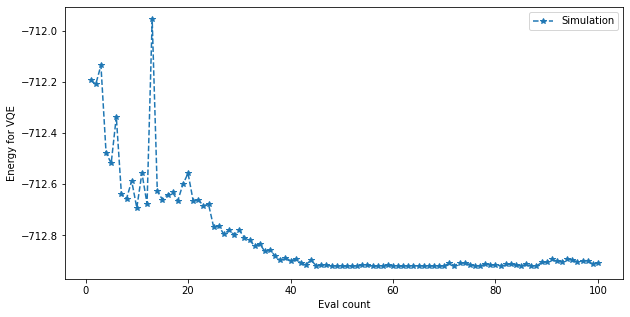

In [25]:

# def plot_energy(counts, vals, optimizers, ref, title_qualifier=""):
plt.figure(figsize=(10,5))
# for i in range(len(optimizers)):
plt.plot(counts, (values),"*--", label="Simulation")
plt.xlabel('Eval count')
plt.ylabel('Energy for VQE')
# plt.title('Energy Convergence of VQE procedure %s' %title_qualifier)
plt.legend(loc='upper right')

In [26]:
selection = np.where(results.x)[0]
print(selection)

# apply quantum feature selection
x_train_q = x_train[:, selection]
x_test_q = x_test[:, selection]

# apply RFE feature selection
x_train_rfe = x_train[:, selection_rfe]
x_test_rfe = x_test[:, selection_rfe]

q_eval = evaluate(estimator, x_train_q, y_train, x_test_q, y_test)
rfe_eval = evaluate(estimator, x_train_rfe, y_train, x_test_rfe, y_test)

print('Approach\tR2\tMSE')
print('------------------------------')
print('Quantum \t%.3f\t%.2f' % (q_eval[0], q_eval[1]))
print('RFE     \t%.3f\t%.2f' % (rfe_eval[0], rfe_eval[1]))

[ 0  2  4  5 10 11]
Approach	R2	MSE
------------------------------
Quantum 	0.836	558.83
RFE     	0.841	540.75


In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

In [ ]:
backend = provider.get_backend('ibmq_manhattan')

In [ ]:
# job.status()
# qc_ = vqe.get_optimal_circuit()
vqe.optimal_params
# qc_.draw()

In [ ]:
initial_layout = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 37] # manhattan layout
# initial_layout = [23, 21, 18, 15, 12, 10, 7, 4, 1, 2, 3, 5, 8] # montreal layout

# optimizer = COBYLA(maxiter=100)
optimizer = SPSA(maxiter=10)
backend = provider.get_backend('ibmq_manhattan')

hardware_counts = []
hardware_values = []
hardware_params = []
hardware_deviation = []

def store_intermediate_result(eval_count, parameters, mean, std):
    hardware_counts.append(eval_count)
    hardware_values.append(mean)
    hardware_params.append(parameters)
    hardware_deviation.append(std)

hardware_qi = QuantumInstance(backend=backend, shots=8192, initial_layout=initial_layout, skip_qobj_validation=False)
hardware_vqe = VQE(var_form=qc_t, quantum_instance=hardware_qi, optimizer=optimizer, callback=store_intermediate_result, initial_point=vqe.optimal_params)

hardware_opt_prob = MinimumEigenOptimizer(hardware_vqe, penalty=0)
# job = execute(hardware_opt_prob.solve(qp), backend)
hardware_results = hardware_opt_prob.solve(qp)

In [ ]:
# selection = np.where([1,0,0,0,1,0,0,1,1,0,0,1,1])[0]
# selection = np.where([1,0,0,0,1,0,0,1,1,1,0,0,1])[0]
selection = np.where(hardware_results.x)[0]

print(selection)

# apply quantum feature selection
x_train_q = x_train[:, selection]
x_test_q = x_test[:, selection]

# apply RFE feature selection
x_train_rfe = x_train[:, selection_rfe]
x_test_rfe = x_test[:, selection_rfe]

q_eval = evaluate(estimator, x_train_q, y_train, x_test_q, y_test)
rfe_eval = evaluate(estimator, x_train_rfe, y_train, x_test_rfe, y_test)

print('Approach\tR2\tMSE')
print('------------------------------')
print('Quantum \t%.3f\t%.2f' % (q_eval[0], q_eval[1]))
print('RFE     \t%.3f\t%.2f' % (rfe_eval[0], rfe_eval[1]))

# def plot_energy(counts, vals, optimizers, ref, title_qualifier=""):
plt.figure(figsize=(10,5))
# for i in range(len(optimizers)):
plt.plot(hardware_counts, (hardware_values),"*--", label="hardware")
# plt.plot(counts, (values),"*--", label="simulation")
plt.xlabel('Eval count')
plt.ylabel('Energy for VQE')
# plt.title('Energy Convergence of VQE procedure %s' %title_qualifier)
plt.legend(loc='upper right')

In [ ]:
hardware_results

In [ ]:
# initial_layout = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 37]
initial_layout = [23, 21, 18, 15, 12, 10, 7, 4, 1, 2, 3, 5, 8] # montreal layout

# optimizer = COBYLA(maxiter=100)
optimizer = SPSA(maxiter=10)
backend = provider.get_backend('ibmq_montreal')

noinitial_hardware_counts = []
noinitial_hardware_values = []
noinitial_hardware_params = []
noinitial_hardware_deviation = []

def store_intermediate_result(eval_count, parameters, mean, std):
    noinitial_hardware_counts.append(eval_count)
    noinitial_hardware_values.append(mean)
    noinitial_hardware_params.append(parameters)
    noinitial_hardware_deviation.append(std)

hardware_qi = QuantumInstance(backend=backend, shots=8192, initial_layout=initial_layout, skip_qobj_validation=False)
hardware_vqe = VQE(var_form=qc_t, quantum_instance=hardware_qi, optimizer=optimizer, callback=store_intermediate_result, initial_point=vqe.optimal_params)

hardware_opt_prob = MinimumEigenOptimizer(hardware_vqe, penalty=0)
# job = execute(hardware_opt_prob.solve(qp), backend)
hardware_results = hardware_opt_prob.solve(qp)

In [37]:
# Make a Docplex model
from docplex.mp.model import Model
total_number_of_countries = 2
lower_limit_array = [0, 0]
upper_limit_array = [2, 2]


mdl = Model('docplex model')
integer_var_list = mdl.integer_var_list(list(range(1, total_number_of_countries + 1)), lb=lower_limit_array, ub=upper_limit_array, name='x')

# Define the binary variables which will be used as the indicator variables
binary_var_list = mdl.binary_var_list(list(range(1, total_number_of_countries + 1)), lb=None, ub=None, name='ib', key_format=None)

cstr_list = [integer_var_list[i] >= total_number_of_countries for i in range(total_number_of_countries)]
indicator_var_list = mdl.add_indicators(binary_var_list, cstr_list, true_values=1, names=['ind1', 'ind2'])



# mdl.minimize(mdl.scal_prod(integer_var_list, average_cost_per_country_array)
#             + mdl.scal_prod(integer_var_list, costs_per_country_with_non_zero_site))
print(mdl.export_as_lp_string())
print("Integer variable list", integer_var_list)
print("Indicator variable list", indicator_var_list)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj:
Subject To
 ind1: ib_1 = 1 -> x_1 >= 2
 ind2: ib_2 = 1 -> x_2 >= 2

Bounds
       x_1 <= 2
       x_2 <= 2
 0 <= ib_1 <= 1
 0 <= ib_2 <= 1

Binaries
 ib_1 ib_2

Generals
 x_1 x_2
End

Integer variable list [docplex.mp.Var(type=I,name='x_1',ub=2), docplex.mp.Var(type=I,name='x_2',ub=2)]
Indicator variable list [docplex.mp.constr.IndicatorConstraint[ind1](ib_1,x_1 >= 2,true=1), docplex.mp.constr.IndicatorConstraint[ind2](ib_2,x_2 >= 2,true=1)]


In [33]:
integer_var_list

[docplex.mp.Var(type=I,name='x_1',ub=2),
 docplex.mp.Var(type=I,name='x_2',ub=2)]